# Introduction

The notebook is intended to experiment with Convolutional Neural Network in PyTorch.

In [1]:
# Import Standard Libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

/Users/s.porreca/.local/share/virtualenvs/cheat_sheets-EiW5VkhA/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

In [2]:
# Define the mean and std of the MNIST dataset for the data normalisation
# NOTE: We are not going to compute them
mean = 0.1307
std = 0.3081

In [3]:
# Define the a set of data transformation through the function "compose"
data_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

In [4]:
# Load the MNIST dataset
train_data = datasets.MNIST(root='./../../data', 
                            train=True, 
                            transform=data_transformations, 
                            download=True)

test_data = datasets.MNIST(root='./../../data',
                           train=False,
                           transform=data_transformations)

In [5]:
# Define a DataLoader for batch training & testing
train_data_loader = torch.utils.data.DataLoader(train_data, 
                                                batch_size=100, 
                                                shuffle=True)

test_data_loader = torch.utils.data.DataLoader(test_data, 
                                               batch_size=100, 
                                               shuffle=False)

# Plot Sample Data

In [6]:
# Retrieve an image and normalise it
image = train_data[20][0].numpy() * mean * std

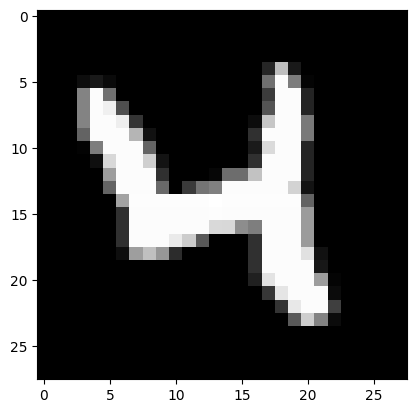

In [7]:
# Show the image
# NOTE: It needs to be reshaped to N x N dimension from a 3-Channel
_ = plt.imshow(image.reshape(28, 28),
               cmap='gray') # Define image gray color

# Model Definition

## Define the Neural Network

In [10]:
class Model(nn.Module):
    
    """
    Initialise a Convolutional Neural Network

    Attributes:
        conv2d_1 nn.Conv2d Convolutional 2-D Layer 1 

    """
    
    def __init__(self, 
                 conv2d_1_attributes: dict, 
                 batch_normalisation_1_attributes: dict, 
                 max_pooling_1_attributes: dict, 
                 conv2d_2_attributes: dict, 
                 batch_normalisation_2_attributes: dict, 
                 max_pooling_2_attributes: dict):
    
        """
        Initialise the Neural Network

        Args:
            conv2d_1_attributes Dictionary of conv2d_1 attributes
            batch_normalisation_1_attributes Dictionary of batch_normalisation_1 attributes
            max_pooling_1_attributes Dictionary of max_pooling_1 attributes
            conv2d_2_attributes Dictionary of conv2d_1 attributes
            batch_normalisation_2_attributes Dictionary of batch_normalisation_2 attributes
            max_pooling_2_attributes Dictionary of max_pooling_2 attributes

        """

        # Call the nn.Module constructor
        super(Model, self).__init__()

        # Define the first Convolutional layer
        self.conv2d_1 = nn.Conv2d(in_channels=conv2d_1_attributes['input_channels'], 
                                  out_channels=conv2d_1_attributes['output_channels'], 
                                  kernel_size=conv2d_1_attributes['kernel_size'], 
                                  stride=conv2d_1_attributes['stride'], 
                                  padding=conv2d_1_attributes['padding'])
        
        # Define the Batch Normalisation layer for conv2d_1
        self.batch_normalisation_1 = nn.BatchNorm2d(batch_normalisation_1_attributes['feature_map_dim'])
        
        # Specify conv2d_1 activation function
        self.activation_function_1 = nn.ReLU()
                 
        # Max Pooling for conv2d_1
        # Note: the final dimension of the feature map after the max_pooling_1 would be
        # [(input_size - kernel_size + 2*padding/stride + 1]
        # 28 - 3 + 2*1/1 + 1 = 28
        # After the MaxPooling: Feature Map Size / Max Pooling Kernel = 28/2 = 14
        self.max_pooling_1 = nn.MaxPool2d(max_pooling_1_attributes['kernel_size'])
        
        # Define the second Convolutional layer
        self.conv2d_2 = nn.Conv2d(in_channels=conv2d_2_attributes['input_channels'], 
                                  out_channels=conv2d_2_attributes['output_channels'], 
                                  kernel_size=conv2d_2_attributes['kernel_size'], 
                                  stride=conv2d_2_attributes['stride'], 
                                  padding=conv2d_2_attributes['padding'])
        
        # Define the Batch Normalisation layer for conv2d_2
        self.batch_normalisation_2 = nn.BatchNorm2d(batch_normalisation_2_attributes['feature_map_dim'])
        
        # Specify conv2d_2 activation function
        self.activation_function_2 = nn.ReLU()
        
        # Max Pooling for conv2d_2
        # Output size: 14 - 5 + 2*2/1 + 1 = 14
        # After Max Pooling: 14/2 = 7
        self.max_pooling_2 = nn.MaxPool2d(max_pooling_2_attributes['kernel_size'])
        
        # Define first fully-connected layer
        # NOTE: The number of neurons is 32x7x7 = 1568
        # NOTE2: 600 is the arbitrary chosen output dimension
        self.fully_connected_1 = nn.Linear(1568, 600)
        
        # Specify fully_connected_1 activation function
        self.activation_function_fcc_1 = nn.ReLU()
        
        # Apply dropout 
        self.dropout = nn.Dropout(0.5)
        
        # Define second fully-connected layer
        # NOTE: the output dimension is 10 because of the number of classes
        self.fully_connected_2 = nn.Linear(600, 10)
                                  
    def forward(self, x):
        """
        Implements the feed forward process of the input x through the CNN
        """
                                  
        # Feed forward the input through the CNN layers
        output_conv2d_1 = self.conv2d_1(x)
        output_conv2d_1 = self.batch_normalisation_1(output_conv2d_1)
        output_conv2d_1 = self.activation_function_1(output_conv2d_1)
        output_conv2d_1 = self.max_pooling_1(output_conv2d_1)
        
        output_conv2d_2 = self.conv2d_2(output_conv2d_1)
        output_conv2d_2 = self.batch_normalisation_2(output_conv2d_2)
        output_conv2d_2 = self.activation_function_2(output_conv2d_2)
        output_conv2d_2 = self.max_pooling_2(output_conv2d_2)
        
        output_fcc_1 = self.fully_connected_1(output_conv2d_2)
        output_fcc_1 = self.activation_function_fcc_1(output_fcc_1)
        output_fcc_1 = self.dropout(output_fcc_1)
        
        output = self.fully_connected_2(output_fcc_1)

In [6]:
# Hyperparameters
conv2d_1_attributes = {
    'input_channels': 1,
    'output_channels': 8, # Number of filters to apply
    'kernel_size': 3,
    'stride': 1,
    'padding': 1 # (kernel_size - 1)/2
}

batch_normalisation_1_attributes = {
    'feature_map_dim': 8
}

max_pooling_1_attributes = {
    'kernel_size': 2
}

conv2d_2_attributes = {
    'input_channels': 8,
    'output_channels': 32, # Number of filters to apply
    'kernel_size': 5,
    'stride': 1,
    'padding': 2 # (kernel_size - 1)/2
}

batch_normalisation_2_attributes = {
    'feature_map_dim': 32
}

max_pooling_2_attributes = {
    'kernel_size': 2
}